# 使用Gluon对CIFAR10进行分类

In [1]:
import mxnet as mx
import numpy as np
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 整理数据

In [2]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [3]:
data_dir = 'data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [4]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4465]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = image.imresize(im, 36, 36)
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=True, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 128
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(128, 3, 32, 32)


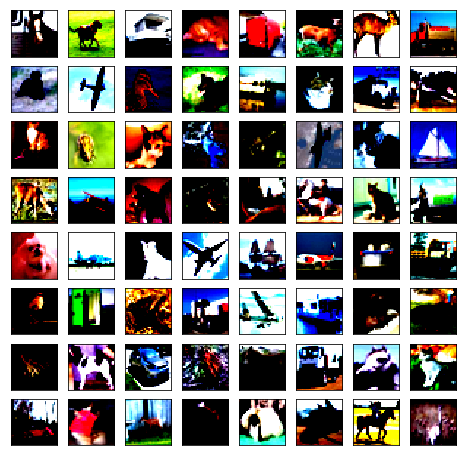

In [5]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## ResNet 164 v2

In [6]:
def BN_ReLU_Conv(num_filter, kernel_size, strides=1, padding=0, erase_relu=False, 
                 erase_conv=False, use_bias=False):
    '''
    num_filter : Int
        The output channel of this unit
    kernel_size : int
        Kernel size of the Conv kernel
    strides : int or tuple
        Conv strides
    padding : int or tuple
        Conv padding
    erase_relu : Boolean
        whether erase relu
    use_bias : Boolean
        Whether use bias
    '''
    unit = gluon.nn.HybridSequential()
    with unit.name_scope():
        unit.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            unit.add(gluon.nn.Activation('relu'))
        if not erase_conv:
            unit.add(gluon.nn.Conv2D(num_filter, kernel_size=kernel_size, strides=strides, 
                                 padding=padding, use_bias=use_bias))
    return unit

def BN_ReLU(erase_relu=False):
    '''
    erase_relu : Boolean
        whether erase relu
    '''
    unit = gluon.nn.HybridSequential()
    with unit.name_scope():
        unit.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            unit.add(gluon.nn.Activation('relu'))
    return unit

class Residual_Unit(gluon.nn.HybridBlock):
    def __init__(self, num_filter, strides, dim_match=True, bottle_neck=False, **kwargs):
        super().__init__(**kwargs)
        self.dim_match = dim_match
        self.bottle_neck = bottle_neck
        residual = self.residual = gluon.nn.HybridSequential()
        with self.name_scope():
            if bottle_neck:
                residual.add(BN_ReLU_Conv(int(num_filter * 0.25), kernel_size=1))  
                residual.add(BN_ReLU_Conv(int(num_filter * 0.25), kernel_size=3, strides=strides, padding=1))
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=1))
            else:
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=3, strides=strides, padding=1))
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=3, strides=1, padding=1))
        if not dim_match:
            self.conv1 = gluon.nn.Conv2D(num_filter, kernel_size=1, strides=strides, use_bias=False)
            self.bn_relu = BN_ReLU()
    
    def hybrid_forward(self, F, X):
        if self.dim_match:
            shortcut = X
        else:
            shortcut = self.conv1(self.bn_relu(X))
        output = self.residual(X)
        return output + shortcut

class ResNet(gluon.nn.HybridBlock):
    def __init__(self, unit_list, filter_list, num_classes, data_type, bottle_neck=False, debug=False, **kwargs):
        '''
        unit_list : list
            num of unit per stage
        filter_list : list
            channnel size of each stage 
        num_classes : int
            num of classes
        bottle_neck : bool
            the bottle_neck archeitecture
        debug : bool
            print the shape of each stage 
        '''
        super().__init__(**kwargs)
        num_stage = len(unit_list)
        self.debug = debug
    
        resnet = self.resnet = gluon.nn.HybridSequential()
        with self.name_scope():
            # first layer 
            blk1 = gluon.nn.HybridSequential()
            blk1.add(gluon.nn.BatchNorm(axis=1))
            if data_type == 'cifar10':
                blk1.add(gluon.nn.Conv2D(filter_list[0], kernel_size=3, padding=1, use_bias=False))
            elif data_type == 'imagenet':
                blk1.add(
                    gluon.nn.Conv2D(filter_list[0], kernel_size=7, strides=2, padding=3, use_bias=False),
                    gluon.nn.BatchNorm(axis=1),
                    gluon.nn.Activation('relu'),
                    gluon.nn.MaxPool2D(pool_size=3, strides=2, padding=1)
                )
            else:
                raise ValueError('do not support {} yet.'.format(data_type))
            resnet.add(blk1)
            
            # residual layer 
            for i in range(num_stage):
                blk2 = gluon.nn.HybridSequential()
                blk2.add(Residual_Unit(filter_list[i+1], 1 if i==0 else 2, False, 
                                      bottle_neck=bottle_neck))
                for j in range(unit_list[i] - 1):
                    blk2.add(Residual_Unit(filter_list[i+1], 1, True, bottle_neck=bottle_neck))
                resnet.add(blk2)
            
            # regularizaiton layer 
            blk3 = gluon.nn.HybridSequential()
            blk3.add(
                gluon.nn.BatchNorm(axis=1),
                gluon.nn.Activation('relu')
            )
            resnet.add(blk3)
            
            # classification layer 
            blk4 = gluon.nn.HybridSequential()
            blk4.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
            resnet.add(blk4)

    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.resnet):
            out = blk(out)
            # if self.debug:
                # print('blk {} : {}'.format(i+1, out.shape))
        return out

In [7]:
depth = 164

if (depth-2)%9 == 0 and depth >= 164:
    per_unit = [int((depth-2)/9)]
    filter_list = [16, 64, 128, 256]
    bottle_neck = True
elif (depth-2)%6 == 0 and depth < 164:
    per_unit = [int((depth-2)/6)]
    filter_list = [16, 16, 32, 64]
    bottle_neck = False
else:
    raise ValueError("depth {} error.".format(depth))
unit_list = per_unit * 3

symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.initialize()
sample = nd.random.uniform(shape=(128, 3, 32, 32))
y = symbol(sample)

In [8]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if 0 <= epoch <= 1:
            trainer.set_learning_rate(0.01)
        if epoch == 2:
            trainer.set_learning_rate(0.1)
        if epoch == 150:
            trainer.set_learning_rate(0.01)
        if epoch == 225:
            trainer.set_learning_rate(0.001)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('sparsenet-cifar10-%d.params' % (epoch))
        else:
            print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss,train_acc, time() - start))

In [9]:
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in'
                                                               , magnitude=2.))
symbol.hybridize()
train(symbol, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.94205, Test Loss : 1.90765, Train Acc : 0.26413, Test Acc : 0.28580, Time Consume 167.487498 s.
[Epoch 1] Train Moving Loss : 1.81929, Test Loss : 1.73892, Train Acc : 0.32156, Test Acc : 0.34900, Time Consume 158.654970 s.
[Epoch 2] Train Moving Loss : 1.64574, Test Loss : 1.60869, Train Acc : 0.37778, Test Acc : 0.40500, Time Consume 157.405118 s.
[Epoch 3] Train Moving Loss : 1.45472, Test Loss : 1.31512, Train Acc : 0.47391, Test Acc : 0.52860, Time Consume 157.402937 s.
[Epoch 4] Train Moving Loss : 1.30119, Test Loss : 1.16920, Train Acc : 0.52002, Test Acc : 0.58840, Time Consume 157.326355 s.
[Epoch 5] Train Moving Loss : 1.15152, Test Loss : 1.04080, Train Acc : 0.57267, Test Acc : 0.64360, Time Consume 153.753538 s.
[Epoch 6] Train Moving Loss : 1.11420, Test Loss : 1.09508, Train Acc : 0.58407, Test Acc : 0.61100, Time Consume 157.668391 s.
[Epoch 7] Train Moving Loss : 1.01939, Test Loss : 0.96391, Train Acc : 0.61413, Test Acc : 0.68380, Tim

[Epoch 64] Train Moving Loss : 0.57849, Test Loss : 0.41344, Train Acc : 0.78924, Test Acc : 0.85560, Time Consume 157.999568 s.
[Epoch 65] Train Moving Loss : 0.51941, Test Loss : 0.42898, Train Acc : 0.78351, Test Acc : 0.85720, Time Consume 158.291123 s.
[Epoch 66] Train Moving Loss : 0.52048, Test Loss : 0.40363, Train Acc : 0.80493, Test Acc : 0.86040, Time Consume 158.062697 s.
[Epoch 67] Train Moving Loss : 0.55600, Test Loss : 0.37976, Train Acc : 0.79878, Test Acc : 0.87260, Time Consume 157.366471 s.
[Epoch 68] Train Moving Loss : 0.54280, Test Loss : 0.42718, Train Acc : 0.80547, Test Acc : 0.86140, Time Consume 157.721467 s.
[Epoch 69] Train Moving Loss : 0.53356, Test Loss : 0.40383, Train Acc : 0.80356, Test Acc : 0.86220, Time Consume 157.682151 s.
[Epoch 70] Train Moving Loss : 0.58415, Test Loss : 0.50597, Train Acc : 0.78753, Test Acc : 0.84440, Time Consume 157.714116 s.
[Epoch 71] Train Moving Loss : 0.53881, Test Loss : 0.42770, Train Acc : 0.79407, Test Acc : 0.85

[Epoch 128] Train Moving Loss : 0.53246, Test Loss : 0.44281, Train Acc : 0.81638, Test Acc : 0.85200, Time Consume 157.286542 s.
[Epoch 129] Train Moving Loss : 0.48633, Test Loss : 0.40678, Train Acc : 0.81807, Test Acc : 0.86240, Time Consume 157.529999 s.
[Epoch 130] Train Moving Loss : 0.50893, Test Loss : 0.36491, Train Acc : 0.82331, Test Acc : 0.88120, Time Consume 157.342270 s.
[Epoch 131] Train Moving Loss : 0.50852, Test Loss : 0.41508, Train Acc : 0.81427, Test Acc : 0.87160, Time Consume 157.428815 s.
[Epoch 132] Train Moving Loss : 0.51959, Test Loss : 0.36177, Train Acc : 0.81033, Test Acc : 0.87540, Time Consume 157.563105 s.
[Epoch 133] Train Moving Loss : 0.50421, Test Loss : 0.33618, Train Acc : 0.82822, Test Acc : 0.88540, Time Consume 157.560066 s.
[Epoch 134] Train Moving Loss : 0.49947, Test Loss : 0.39877, Train Acc : 0.81918, Test Acc : 0.87940, Time Consume 157.574318 s.
[Epoch 135] Train Moving Loss : 0.52219, Test Loss : 0.37451, Train Acc : 0.81498, Test Ac

[Epoch 192] Train Moving Loss : 0.27014, Test Loss : 0.22930, Train Acc : 0.92073, Test Acc : 0.93200, Time Consume 157.132994 s.
[Epoch 193] Train Moving Loss : 0.24192, Test Loss : 0.22766, Train Acc : 0.91976, Test Acc : 0.93660, Time Consume 157.387278 s.
[Epoch 194] Train Moving Loss : 0.25593, Test Loss : 0.22108, Train Acc : 0.92056, Test Acc : 0.93520, Time Consume 157.768492 s.
[Epoch 195] Train Moving Loss : 0.24795, Test Loss : 0.23234, Train Acc : 0.92127, Test Acc : 0.93000, Time Consume 157.333016 s.
[Epoch 196] Train Moving Loss : 0.23336, Test Loss : 0.23011, Train Acc : 0.91993, Test Acc : 0.93040, Time Consume 157.445297 s.
[Epoch 197] Train Moving Loss : 0.21657, Test Loss : 0.21989, Train Acc : 0.92313, Test Acc : 0.93460, Time Consume 157.649496 s.
[Epoch 198] Train Moving Loss : 0.26111, Test Loss : 0.22854, Train Acc : 0.91942, Test Acc : 0.93200, Time Consume 157.234720 s.
[Epoch 199] Train Moving Loss : 0.25541, Test Loss : 0.23822, Train Acc : 0.92184, Test Ac

[Epoch 256] Train Moving Loss : 0.18244, Test Loss : 0.22802, Train Acc : 0.93896, Test Acc : 0.94280, Time Consume 159.183869 s.
[Epoch 257] Train Moving Loss : 0.18714, Test Loss : 0.21981, Train Acc : 0.93616, Test Acc : 0.94220, Time Consume 158.588704 s.
[Epoch 258] Train Moving Loss : 0.19586, Test Loss : 0.22126, Train Acc : 0.94071, Test Acc : 0.94180, Time Consume 157.282675 s.
[Epoch 259] Train Moving Loss : 0.18191, Test Loss : 0.22408, Train Acc : 0.93731, Test Acc : 0.94140, Time Consume 157.078075 s.
[Epoch 260] Train Moving Loss : 0.18196, Test Loss : 0.22085, Train Acc : 0.93769, Test Acc : 0.94400, Time Consume 157.329846 s.
[Epoch 261] Train Moving Loss : 0.22272, Test Loss : 0.22452, Train Acc : 0.93769, Test Acc : 0.94080, Time Consume 157.959900 s.
[Epoch 262] Train Moving Loss : 0.18934, Test Loss : 0.21990, Train Acc : 0.93956, Test Acc : 0.94120, Time Consume 157.335332 s.
[Epoch 263] Train Moving Loss : 0.20545, Test Loss : 0.22225, Train Acc : 0.93780, Test Ac

In [13]:
import pandas as pd

ctx = mx.gpu()
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in'
                                                               , magnitude=2.))
symbol.hybridize()
train(symbol, train_data, None, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.92231, Train Acc : 0.25264, Time Consume 137.605628 s.
[Epoch 1] Train Moving Loss : 1.77952, Train Acc : 0.34267, Time Consume 134.386185 s.
[Epoch 2] Train Moving Loss : 1.64886, Train Acc : 0.37416, Time Consume 134.248772 s.
[Epoch 3] Train Moving Loss : 1.44344, Train Acc : 0.47082, Time Consume 134.273148 s.
[Epoch 4] Train Moving Loss : 1.34554, Train Acc : 0.53024, Time Consume 134.117615 s.
[Epoch 5] Train Moving Loss : 1.18612, Train Acc : 0.55031, Time Consume 134.231488 s.
[Epoch 6] Train Moving Loss : 1.09895, Train Acc : 0.60593, Time Consume 134.116247 s.
[Epoch 7] Train Moving Loss : 1.04545, Train Acc : 0.59513, Time Consume 134.070244 s.
[Epoch 8] Train Moving Loss : 0.96505, Train Acc : 0.63911, Time Consume 134.069406 s.
[Epoch 9] Train Moving Loss : 0.96632, Train Acc : 0.66229, Time Consume 133.987555 s.
[Epoch 10] Train Moving Loss : 0.93646, Train Acc : 0.67391, Time Consume 134.016881 s.
[Epoch 11] Train Moving Loss : 0.86914, Tr

[Epoch 94] Train Moving Loss : 0.52024, Train Acc : 0.79322, Time Consume 134.021999 s.
[Epoch 95] Train Moving Loss : 0.56786, Train Acc : 0.80487, Time Consume 134.079906 s.
[Epoch 96] Train Moving Loss : 0.51033, Train Acc : 0.81416, Time Consume 134.049448 s.
[Epoch 97] Train Moving Loss : 0.53123, Train Acc : 0.80409, Time Consume 134.061451 s.
[Epoch 98] Train Moving Loss : 0.54185, Train Acc : 0.80571, Time Consume 134.014992 s.
[Epoch 99] Train Moving Loss : 0.50440, Train Acc : 0.80800, Time Consume 134.097715 s.
[Epoch 100] Train Moving Loss : 0.53735, Train Acc : 0.81416, Time Consume 133.966410 s.
[Epoch 101] Train Moving Loss : 0.55541, Train Acc : 0.80449, Time Consume 133.987976 s.
[Epoch 102] Train Moving Loss : 0.55561, Train Acc : 0.80922, Time Consume 134.112890 s.
[Epoch 103] Train Moving Loss : 0.57471, Train Acc : 0.80900, Time Consume 134.081670 s.
[Epoch 104] Train Moving Loss : 0.51620, Train Acc : 0.80087, Time Consume 133.949252 s.
[Epoch 105] Train Moving Lo

[Epoch 187] Train Moving Loss : 0.24774, Train Acc : 0.91949, Time Consume 134.080812 s.
[Epoch 188] Train Moving Loss : 0.25022, Train Acc : 0.91822, Time Consume 134.012660 s.
[Epoch 189] Train Moving Loss : 0.24188, Train Acc : 0.91942, Time Consume 133.998591 s.
[Epoch 190] Train Moving Loss : 0.26659, Train Acc : 0.92013, Time Consume 134.068174 s.
[Epoch 191] Train Moving Loss : 0.24598, Train Acc : 0.92024, Time Consume 134.090090 s.
[Epoch 192] Train Moving Loss : 0.25193, Train Acc : 0.92149, Time Consume 134.218830 s.
[Epoch 193] Train Moving Loss : 0.23585, Train Acc : 0.92193, Time Consume 134.004400 s.
[Epoch 194] Train Moving Loss : 0.26020, Train Acc : 0.92024, Time Consume 134.029416 s.
[Epoch 195] Train Moving Loss : 0.23437, Train Acc : 0.92064, Time Consume 134.026414 s.
[Epoch 196] Train Moving Loss : 0.22318, Train Acc : 0.92004, Time Consume 133.964703 s.
[Epoch 197] Train Moving Loss : 0.24906, Train Acc : 0.92169, Time Consume 134.057921 s.
[Epoch 198] Train Mov

[Epoch 280] Train Moving Loss : 0.19917, Train Acc : 0.93820, Time Consume 134.008828 s.
[Epoch 281] Train Moving Loss : 0.17413, Train Acc : 0.93924, Time Consume 133.996777 s.
[Epoch 282] Train Moving Loss : 0.18957, Train Acc : 0.93853, Time Consume 134.028482 s.
[Epoch 283] Train Moving Loss : 0.17368, Train Acc : 0.94036, Time Consume 143.201688 s.
[Epoch 284] Train Moving Loss : 0.17227, Train Acc : 0.93978, Time Consume 150.332560 s.
[Epoch 285] Train Moving Loss : 0.19208, Train Acc : 0.94022, Time Consume 149.768489 s.
[Epoch 286] Train Moving Loss : 0.21027, Train Acc : 0.94080, Time Consume 151.915735 s.
[Epoch 287] Train Moving Loss : 0.19394, Train Acc : 0.93827, Time Consume 150.979716 s.
[Epoch 288] Train Moving Loss : 0.19009, Train Acc : 0.93933, Time Consume 150.110973 s.
[Epoch 289] Train Moving Loss : 0.19769, Train Acc : 0.93951, Time Consume 149.880435 s.
[Epoch 290] Train Moving Loss : 0.19220, Train Acc : 0.94198, Time Consume 150.070234 s.
[Epoch 291] Train Mov

NameError: name 'sparsenet' is not defined

In [14]:
preds = []
for data, label in test_data:
     output = symbol(data.as_in_context(ctx))
     preds.extend(output.argmax(axis=1).astype(int).asnumpy())

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key = lambda x:str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)